In [1]:
# Extra packages that we will use
# !pip install tensorflow  

# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import time
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

There are three types of gates within a unit:

- Forget Gate: conditionally decides what information to throw away from the block. 
- Input Gate: conditionally decides which values from the input to update the memory state. 
- Output Gate: conditionally decides what to output based on input and the memory of the block.# LSTM Network

The Long Short-Term Memory network (LSTM) is a type of Recurrent Neural Network (RNN). A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.

By default, an LSTM layer in Keras maintains state between data within one batch. A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine-grained control over when state of the LSTM layer is cleared, by calling the reset_states() function.

The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].

- Samples: These are independent observations from the domain, typically rows of data. 
- Time steps: These are separate time steps of a given variable for a given observation. 
- Features: These are separate measures observed at the time of observation. We have some flexibility in how the dataset is framed for the network. 

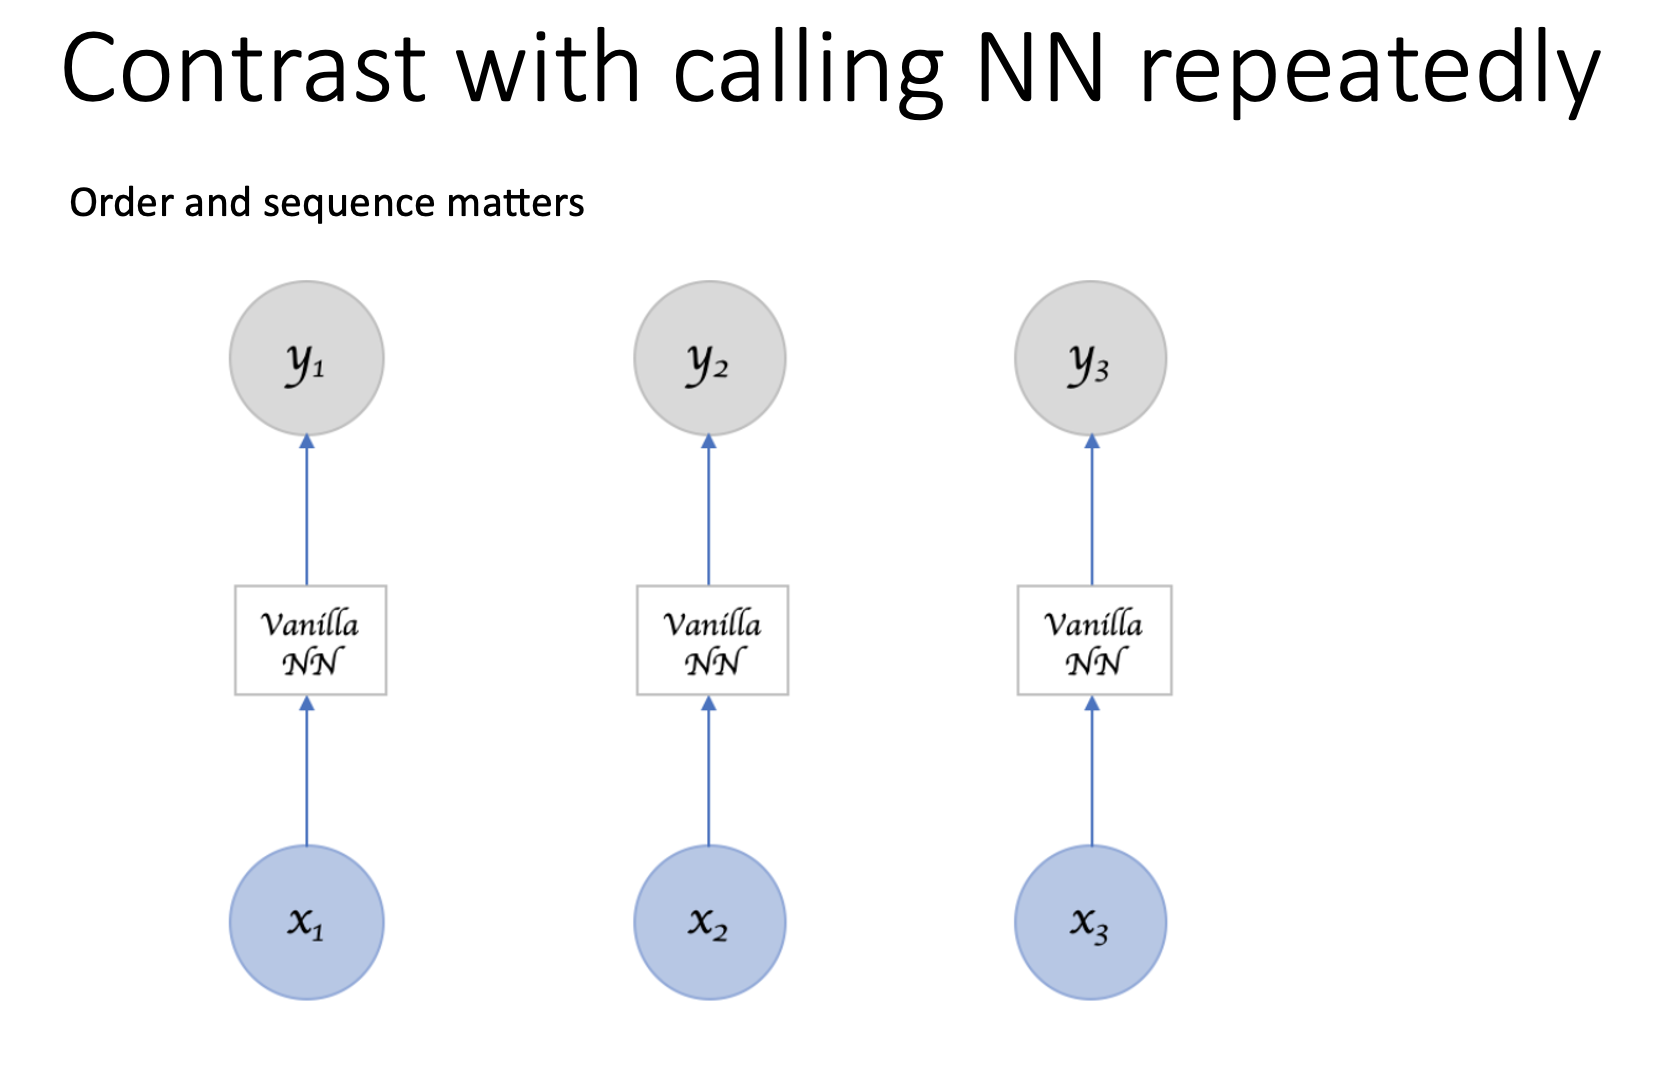

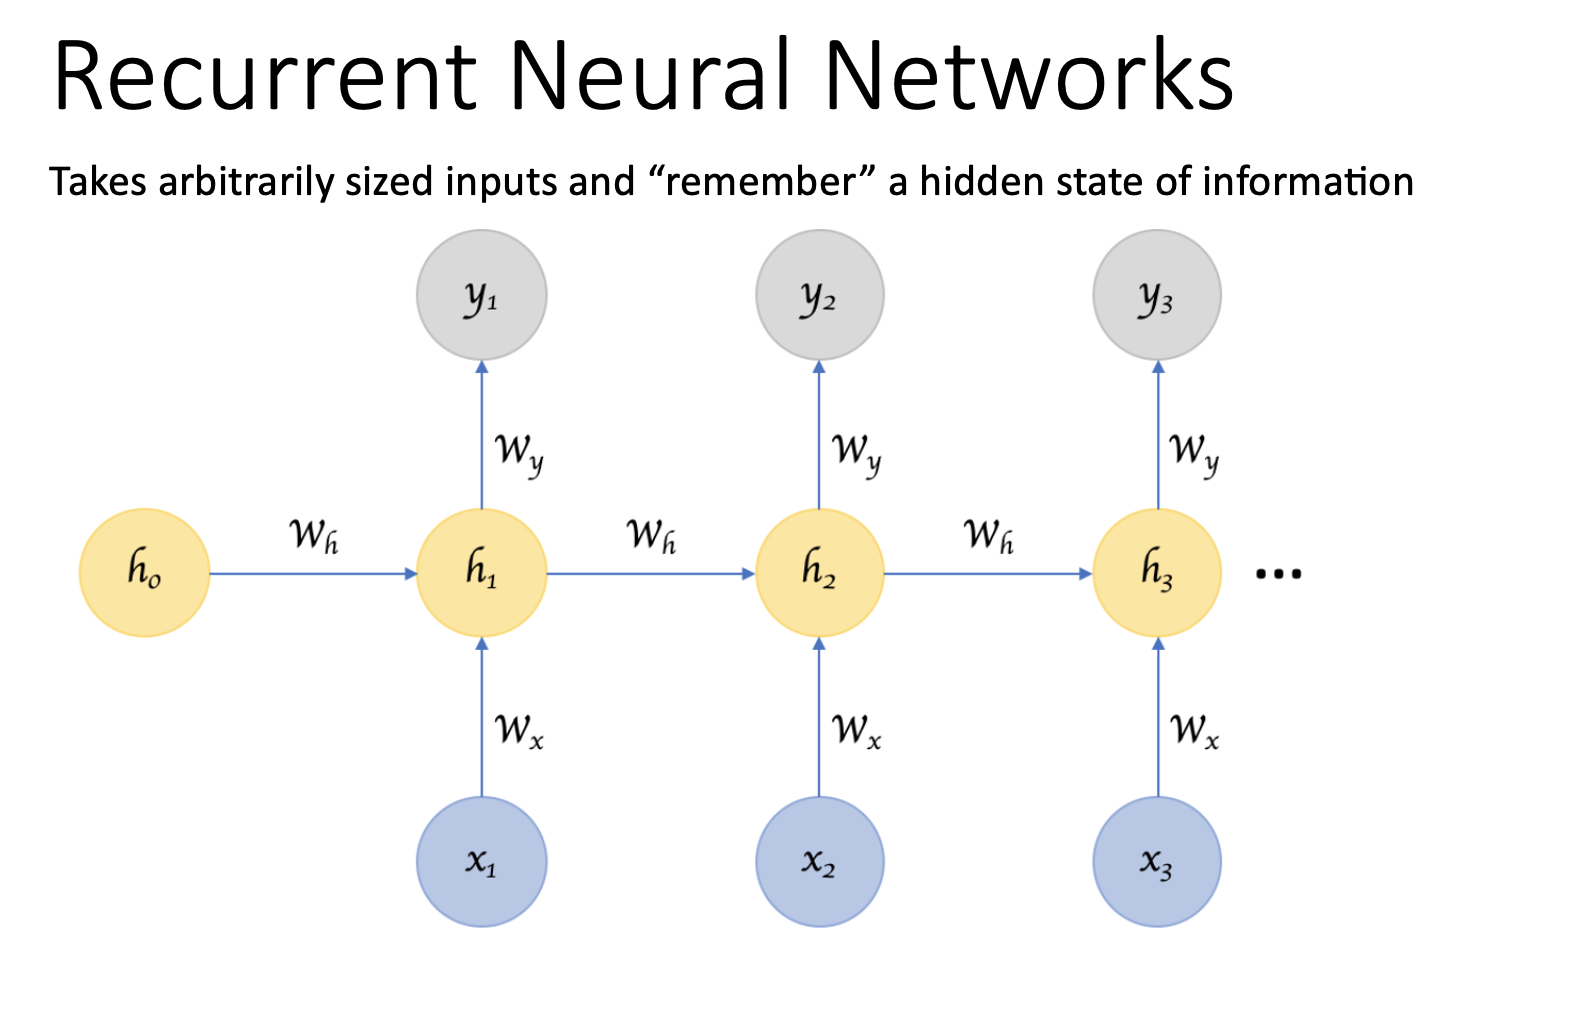
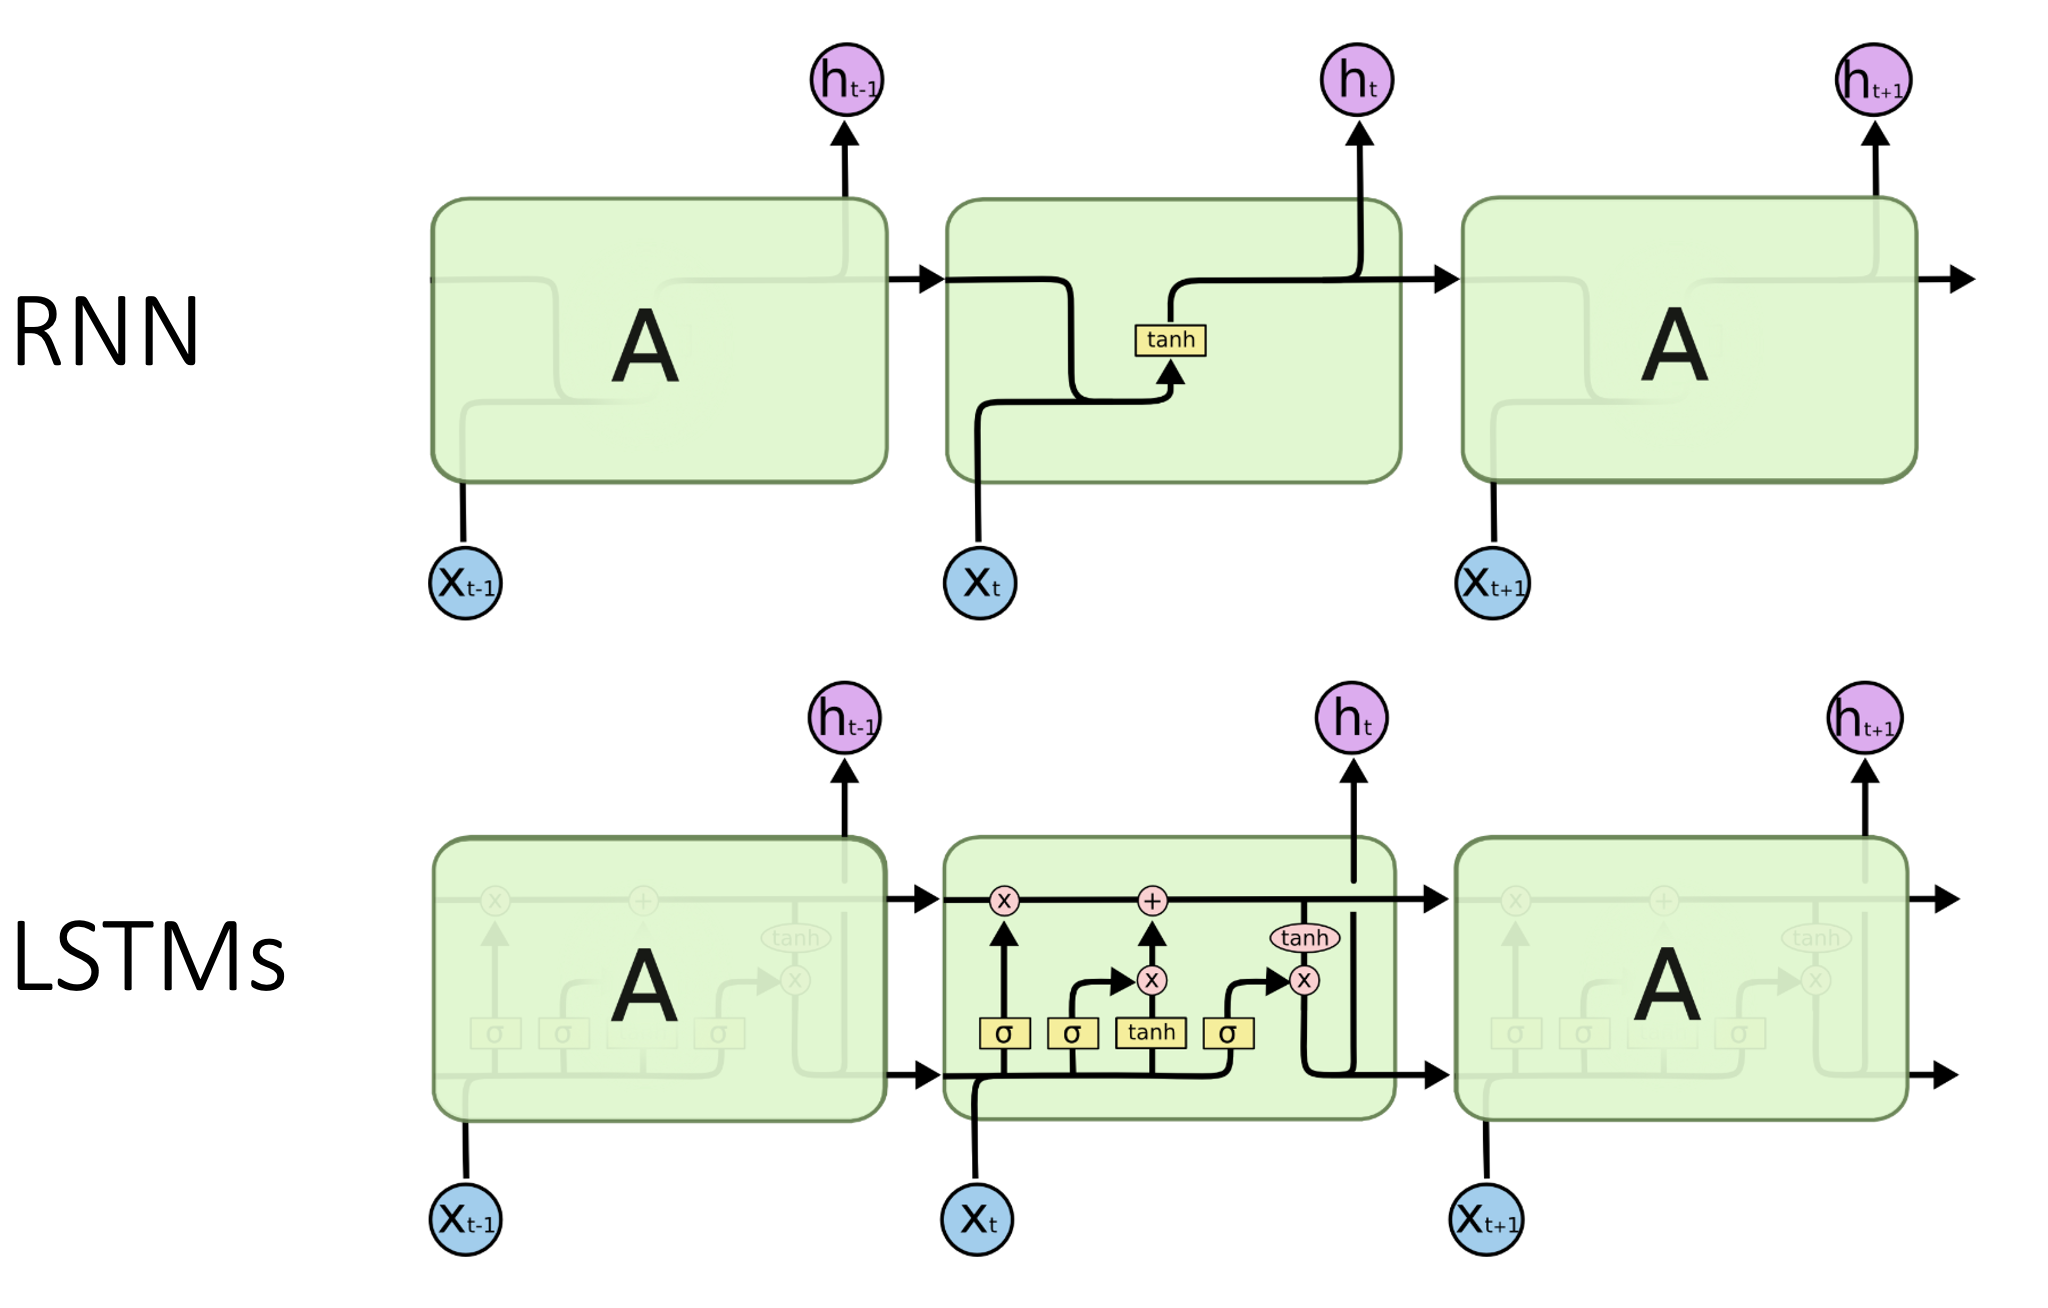
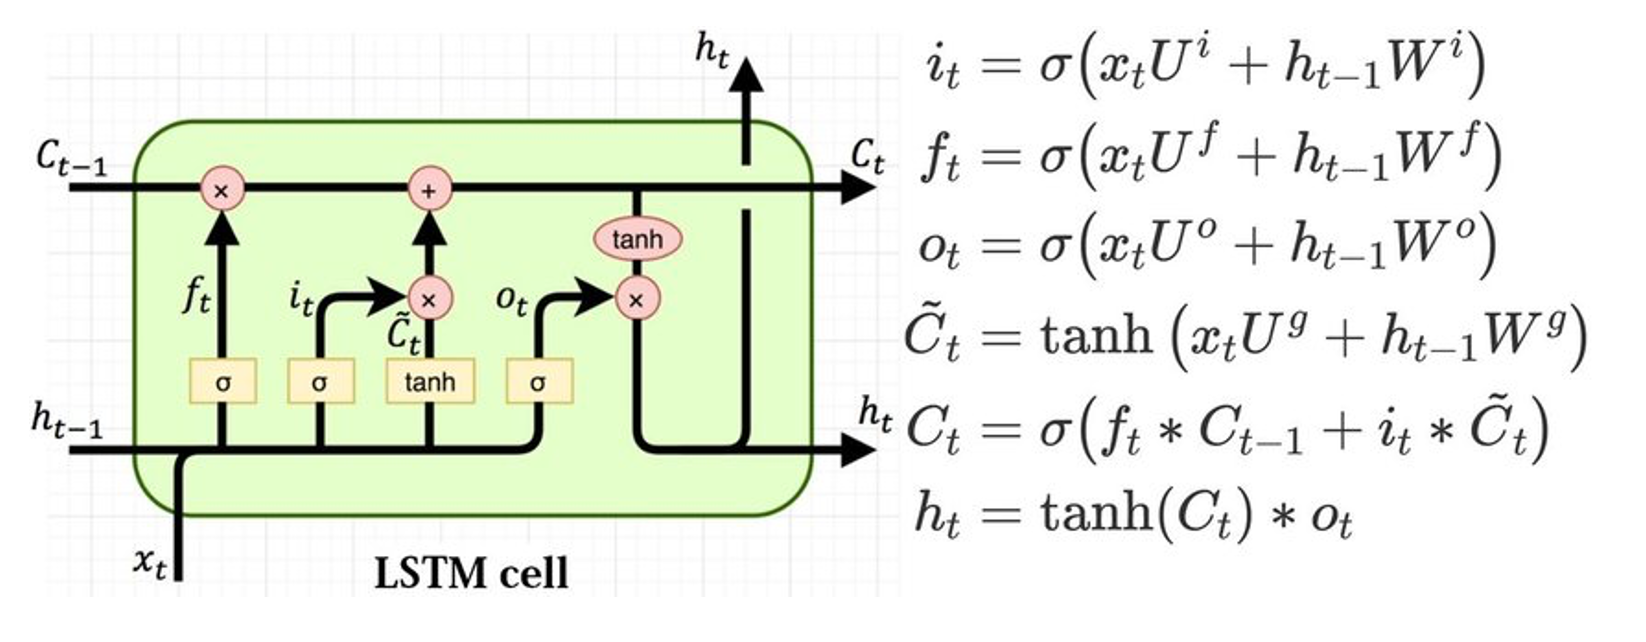

There are three types of gates within a unit: 
- Forget Gate: conditionally decides what information to throw away from the block. 
- Input Gate: conditionally decides which values from the input to update the memory state. 
- Output Gate: conditionally decides what to output based on input and the memory of the block.

In [2]:
# fix random seed for reproducibility
np.random.seed(7)

In [10]:
# load the dataset (inspired on https://climate.nasa.gov/scientific-consensus/)
dataframe = pd.read_csv('../Climate/climate.csv')#, usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

## The real data
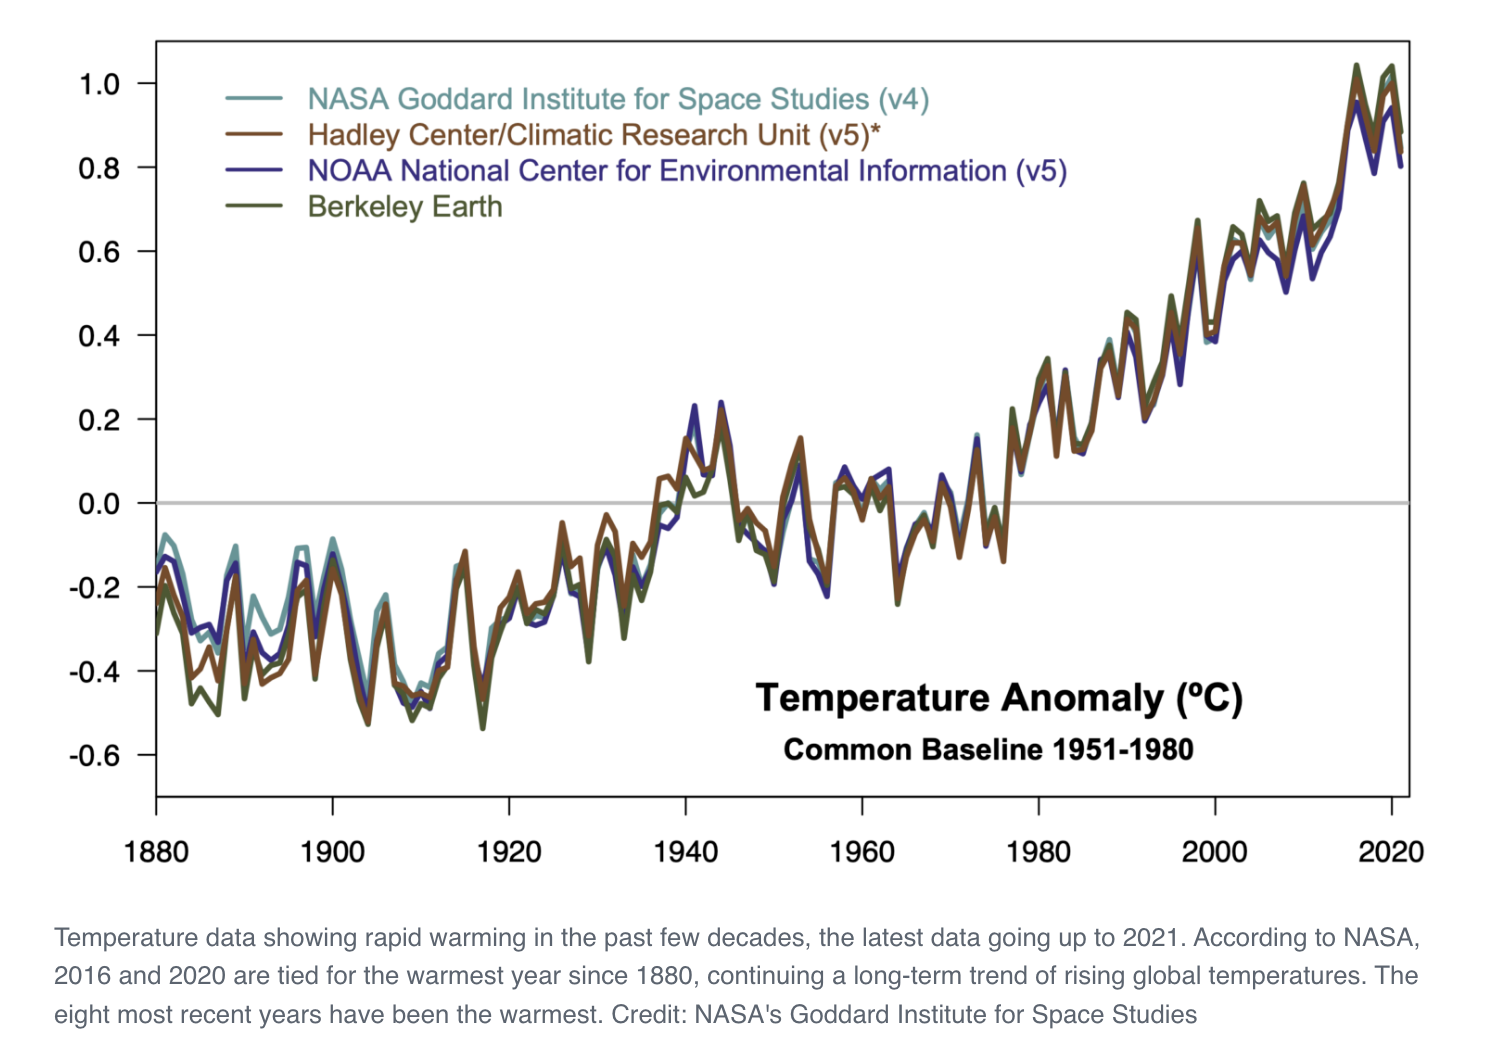

         date  Temp Anomaly
0  1960.00000      0.000000
1  1960.41958      0.009646
2  1960.83916      0.032154
3  1961.25874      0.027331
4  1961.67832      0.014469


Text(0.5, 1.0, 'Fake dataset')

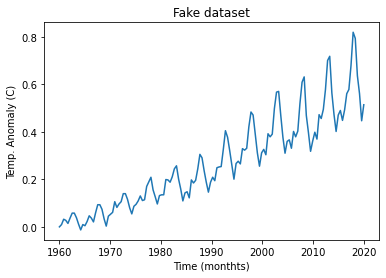

In [11]:
# Inspect the dataset
print(dataframe.head())
plt.plot(dataset[:,0],dataset[:,1])
plt.xlabel('Time (monthts)')
plt.ylabel('Temp. Anomaly (C)')
plt.title('Fake dataset')

In [5]:
# normalize the dataset
print(dataset.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

(144, 2)


In [6]:
# split into train and test sets
dataframe = pd.read_csv('../Climate/climate.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

print('len(dataset): ',len(dataset))
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

len(dataset):  144
96 48


In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

We have some flexibility in how the dataset is framed for the network. We will keep it simple and frame the problem as each time step in the original sequence is one separate sample, with one timestep and one feature.

In [8]:
## Let's train the LSTM using SGD as optimizer
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('testX.shape: ',testX.shape)
print('trainX[:5]: ', trainX[:5,:,:].flatten())
print('trainY[:5]: ', trainY[:5])


# create and fit the LSTM network
if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) # hidden layer with 4 LSTM blocks or neurons, with time_step=1 and features=1.
model.add(Dense(1)) # output layer that makes a single value prediction

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.optimizers.SGD(learning_rate=0.01))

# Fit the model
history = model.fit(trainX, trainY, epochs=300, batch_size=1, verbose=0, validation_data=(testX, testY))
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

trainX.shape:  (94, 1, 1)
trainY.shape:  (94,)
testX.shape:  (46, 1, 1)
trainX[:5]:  [0.01544402 0.02702703 0.05405406 0.04826255 0.03281853]
trainY[:5]:  [0.02702703 0.05405406 0.04826255 0.03281853 0.05984557]


2022-06-13 16:55:57.611732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


keys:  dict_keys(['loss', 'val_loss'])
--- Elapsed time: 31.93408489227295 seconds ---


In [48]:
# summarize history for loss
def plot_hist(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','val'], loc='upper left')
    plt.show()

# make predictions
def make_preds(trainX,trainY,testX,testY):
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    print('Train R^2: ', r2_score(trainY[0], trainPredict[:,0]))
    testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    print('Test R^2: ', r2_score(testY[0], testPredict[:,0]))

    return trainPredict, testPredict

# shift train predictions for plotting
def plot_preds(trainPredict,testPredict):
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

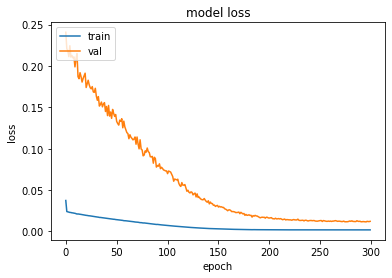

In [49]:
plot_hist(history)

In [50]:
trainPredict, testPredict = make_preds(trainX,trainY,testX,testY)

2/2 [==============================] - 0s 2ms/step
Train Score: 0.04 RMSE
Train R^2:  0.8983784437818891
Test Score: 0.09 RMSE
Test R^2:  0.4585090347416374


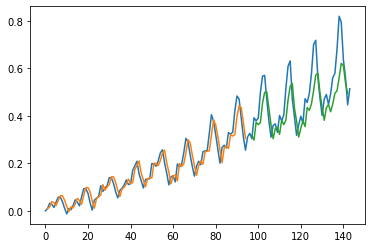

In [51]:
plot_preds(trainPredict,testPredict)

Question: Now that you are an expert in Neural Nets design, what else would you change in this model in order to make it better?

Look at the configs used by the [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

In [25]:
# Let's redo it using ADAM
# reshape into X=t and Y=t+1
look_back = 1
# our data is in the form: [samples, features]
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: ', trainX[:5,:,:].flatten())
print('trainY[:5]: ', trainY[:5])

# create and fit the LSTM network
if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) 
model.add(Dense(1)) 

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(learning_rate=0.001))

# Fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0, validation_data=(testX, testY))
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

trainX.shape:  (94, 1, 1)
trainY.shape:  (94,)
trainX[:5]:  [0.01544402 0.02702703 0.05405406 0.04826255 0.03281853]
trainY[:5]:  [0.02702703 0.05405406 0.04826255 0.03281853 0.05984557]
Deleting "model"
keys:  dict_keys(['loss', 'val_loss'])
--- Elapsed time: 11.610872983932495 seconds ---


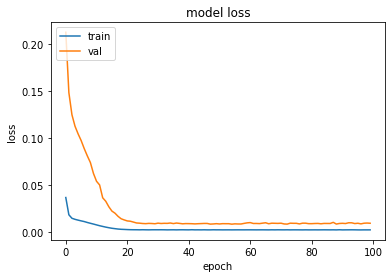

In [26]:
plot_hist(history)

In [27]:
trainPredict, testPredict = make_preds(trainX,trainY,testX,testY)

2/2 [==============================] - 0s 2ms/step
Train Score: 0.04 RMSE
Train R^2:  0.8973066925104927
Test Score: 0.08 RMSE
Test R^2:  0.6008098394369548


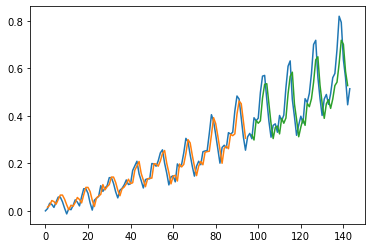

In [28]:
plot_preds(trainPredict,testPredict)

## LSTM for Regression Using the Window Method

We have been using a single feauture/time step to perform prediction. What if we use more samples to perform the prediction?

In [29]:
 # reshape into X=t and Y=t+3
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: \n', trainX[:5])
print('trainY[:5]: \n', trainY[:5])

trainX.shape:  (92, 3)
trainY.shape:  (92,)
trainX[:5]: 
 [[0.01544402 0.02702703 0.05405406]
 [0.02702703 0.05405406 0.04826255]
 [0.05405406 0.04826255 0.03281853]
 [0.04826255 0.03281853 0.05984557]
 [0.03281853 0.05984557 0.08494209]]
trainY[:5]: 
 [0.04826255 0.03281853 0.05984557 0.08494209 0.08494209]


In [30]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: \n', trainX[:5])
print('trainY[:5]: \n', trainY[:5])

# create and fit the LSTM network
if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0, validation_data=(testX, testY))
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

trainX.shape:  (92, 1, 3)
trainY.shape:  (92,)
trainX[:5]: 
 [[[0.01544402 0.02702703 0.05405406]]

 [[0.02702703 0.05405406 0.04826255]]

 [[0.05405406 0.04826255 0.03281853]]

 [[0.04826255 0.03281853 0.05984557]]

 [[0.03281853 0.05984557 0.08494209]]]
trainY[:5]: 
 [0.04826255 0.03281853 0.05984557 0.08494209 0.08494209]
Deleting "model"
keys:  dict_keys(['loss', 'val_loss'])
--- Elapsed time: 11.916315078735352 seconds ---


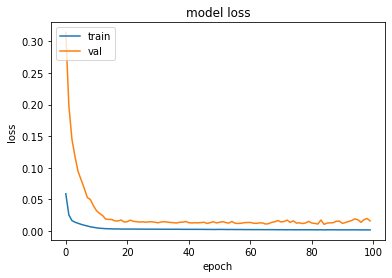

In [31]:
plot_hist(history)

In [32]:
trainPredict, testPredict = make_preds(trainX,trainY,testX,testY)

2/2 [==============================] - 0s 2ms/step
Train Score: 0.04 RMSE
Train R^2:  0.9004872597023564
Test Score: 0.11 RMSE
Test R^2:  0.27320511136417924


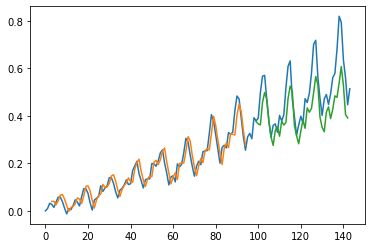

In [33]:
plot_preds(trainPredict,testPredict)

Question: Compare the performance obtained on single points versus the window method. What are the advantages of one versus the other?

## LSTM for Regression with Time Steps

Now we will reformulate the problem: instead of dealing with the past observations as independent features, we will consider them as time steps of one input feature.

In [34]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: \n', trainX[:5])
print('trainY[:5]: \n', trainY[:5])

# create and fit the LSTM network
if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1))) # with time_step=3 and 1 feature.
model.add(Dense(1))

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0, validation_data=(testX, testY))
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

trainX.shape:  (92, 3, 1)
trainY.shape:  (92,)
trainX[:5]: 
 [[[0.01544402]
  [0.02702703]
  [0.05405406]]

 [[0.02702703]
  [0.05405406]
  [0.04826255]]

 [[0.05405406]
  [0.04826255]
  [0.03281853]]

 [[0.04826255]
  [0.03281853]
  [0.05984557]]

 [[0.03281853]
  [0.05984557]
  [0.08494209]]]
trainY[:5]: 
 [0.04826255 0.03281853 0.05984557 0.08494209 0.08494209]
Deleting "model"
keys:  dict_keys(['loss', 'val_loss'])
--- Elapsed time: 12.65823483467102 seconds ---


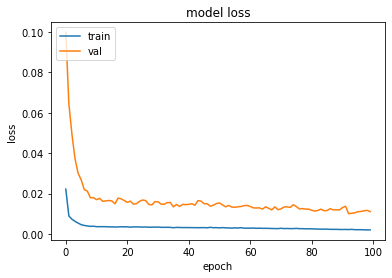

In [35]:
plot_hist(history)

In [36]:
trainPredict, testPredict = make_preds(trainX,trainY,testX,testY)

2/2 [==============================] - 0s 2ms/step
Train Score: 0.04 RMSE
Train R^2:  0.8974523663538914
Test Score: 0.09 RMSE
Test R^2:  0.5021745644386617


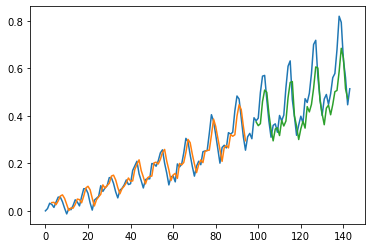

In [37]:
plot_preds(trainPredict,testPredict)

## LSTM with Memory Between Batches

In order to prevent the LSTM to find dependencies between your batches, it is set to be “stateless” by default. But what if the dependency between the batches is somehow informative for LSTM to learn? Let’s see what happens when we let the LSTM to build state over the entire training sequence.

In [38]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1

if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))

start_time = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    history = model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, validation_data=(testX, testY))
    model.reset_states()
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

Deleting "model"
keys:  dict_keys(['loss', 'val_loss'])
--- Elapsed time: 17.505539655685425 seconds ---


In [39]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size) #Now we need to specify the batch_size
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Train R^2: ', r2_score(trainY[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print('Test R^2: ', r2_score(testY[0], testPredict[:,0]))

44/44 [==============================] - 0s 911us/step
Train Score: 0.04 RMSE
Train R^2:  0.8456616738615461
Test Score: 0.10 RMSE
Test R^2:  0.3831366682611168


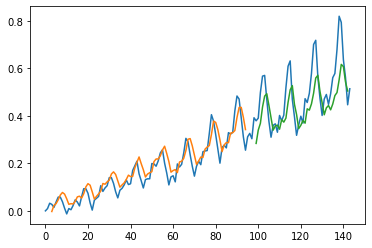

In [40]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Stacked LSTMs with Memory Between Batches

In [41]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1

if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))

start_time = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(500):
    history = model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, validation_data=(testX, testY))
    model.reset_states()
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

Deleting "model"
keys:  dict_keys(['loss', 'val_loss'])
--- Elapsed time: 108.016756772995 seconds ---


44/44 [==============================] - 0s 770us/step
Train Score: 0.03 RMSE
Train R^2:  0.9162506832880468
Test Score: 0.12 RMSE
Test R^2:  0.11206466691333383


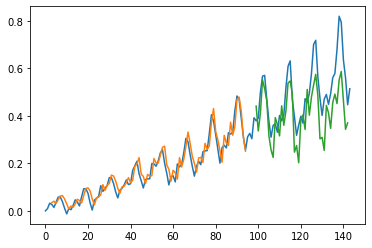

In [42]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size) #Now we need to specify the batch_size
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Train R^2: ', r2_score(trainY[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print('Test R^2: ', r2_score(testY[0], testPredict[:,0]))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Adding Early Stopping

A problem with training neural networks is in the choice of the number of training epochs to use.

Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.

In [43]:
# Using Early stopping
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
batch_size=1
print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: ', trainX[:5].flatten())
print('trainY[:5]: ', trainY[:5])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('./models/best_model_LSTM.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size,1,look_back), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, 1,look_back), stateful=True))
model.add(Dense(1))

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1, validation_data=(testX, testY),callbacks=[es, mc])
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

# load the saved model
model = load_model('./models/best_model_LSTM.h5')

trainX.shape:  (92, 1, 3)
trainY.shape:  (92,)
trainX[:5]:  [0.01544402 0.02702703 0.05405406 0.02702703 0.05405406 0.04826255
 0.05405406 0.04826255 0.03281853 0.04826255 0.03281853 0.05984557
 0.03281853 0.05984557 0.08494209]
trainY[:5]:  [0.04826255 0.03281853 0.05984557 0.08494209 0.08494209]
Deleting "model"
Epoch 1/100
84/92 [==========================>...] - ETA: 0s - loss: 0.0379 
Epoch 1: val_loss improved from inf to 0.09698, saving model to ./models/best_model_LSTM.h5
92/92 [==============================] - 2s 7ms/step - loss: 0.0368 - val_loss: 0.0970
Epoch 2/100
92/92 [==============================] - ETA: 0s - loss: 0.0197
Epoch 2: val_loss did not improve from 0.09698
92/92 [==============================] - 0s 2ms/step - loss: 0.0197 - val_loss: 0.1133
Epoch 3/100
47/92 [==============>...............] - ETA: 0s - loss: 0.0182
Epoch 3: val_loss did not improve from 0.09698
92/92 [==============================] - 0s 1ms/step - loss: 0.0189 - val_loss: 0.0976
Epoch 4/

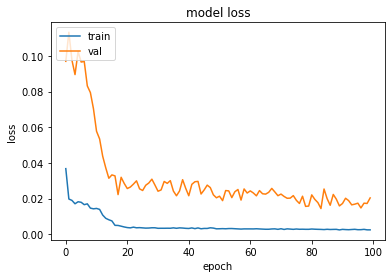

In [44]:
plot_hist(history)

44/44 [==============================] - 0s 693us/step
Train Score: 0.05 RMSE
Train R^2:  0.7882115944144001
Test Score: 0.10 RMSE
Test R^2:  0.363344195136559


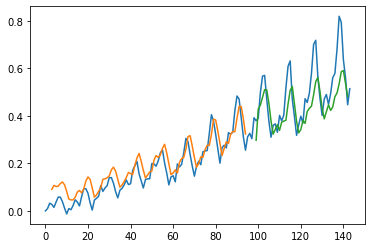

In [45]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size) #Now we need to specify the batch_size
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore =  np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Train R^2: ', r2_score(trainY[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print('Test R^2: ', r2_score(testY[0], testPredict[:,0]))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

trainX.shape:  (92, 1, 3)
trainY.shape:  (92,)
trainX[:5]:  [0.01544402 0.02702703 0.05405406 0.02702703 0.05405406 0.04826255
 0.05405406 0.04826255 0.03281853 0.04826255 0.03281853 0.05984557
 0.03281853 0.05984557 0.08494209]
trainY[:5]:  [0.04826255 0.03281853 0.05984557 0.08494209 0.08494209]
Deleting "model"
keys:  dict_keys(['loss', 'val_loss'])
--- Elapsed time: 27.593353986740112 seconds ---


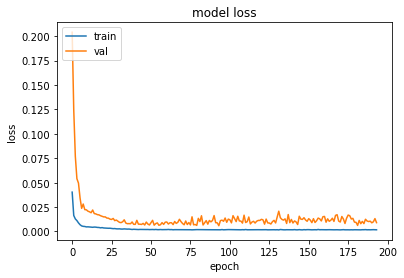

44/44 [==============================] - 0s 698us/step
Train Score: 0.04 RMSE
Train R^2:  0.8607555149559536
Test Score: 0.06 RMSE
Test R^2:  0.7335385934742549


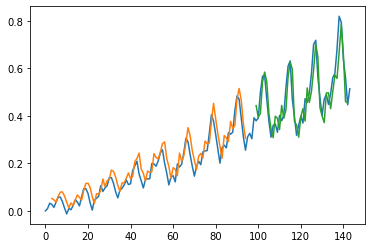

In [46]:
# Try more nodes in the LSTM
# Using Early stopping

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: ', trainX[:5].flatten())
print('trainY[:5]: ', trainY[:5])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=100)
mc = ModelCheckpoint('./models/best_model_LSTM.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(8, batch_input_shape=(batch_size,1,look_back), return_sequences=True))
model.add(LSTM(8, batch_input_shape=(batch_size, 1,look_back)))
model.add(Dense(1))

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(trainX, trainY, epochs=1000, batch_size=1, verbose=0, validation_data=(testX, testY),callbacks=[es, mc])
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

# load the saved model
model = load_model('./models/best_model_LSTM.h5')

plot_hist(history)

# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size) #Now we need to specify the batch_size
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Train R^2: ', r2_score(trainY[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print('Test R^2: ', r2_score(testY[0], testPredict[:,0]))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


# Now it is your turn!!!
Use the concepts above to model pollution in a city. 

## Multivariate Time-series - Data
We are given a dataset of multiple features which affect the amount of pollution in air, which are being recorded with a sampling rate of 1 hr, for 5 years.

We want to use this data to predict the air pollution content for the test data. 

This dataset contains an example of weather conditions data set where we will have attributes/ columns/ like pollution, dew, temp, wind direction, wind speed, snow, rain. Now we will use the Multivariate LSTM time series forecasting technique to predict the pollution for the next hours based on pollution, dew, temp, wind speed, snow, rain conditions.

Now let's have a look at this dataset. 


In [2]:
# Load data
df = pd.read_csv("./data/LSTM-Multivariate_pollution.csv")

In [3]:
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


- data: Sequence of observations as a list or 2D NumPy array. Required.
- n_in: Number of lag observations as input (X). Values may be between [1..len(data)] Optional. Defaults to 1.
- n_out: Number of observations as output (y). Values may be between [0..len(data)-1]. Optional. Defaults to 1.
- dropnan: Boolean whether or not to drop rows with NaN values. Optional. Defaults to True.


In [4]:
# The function is defined with default parameters so that if you call it with just your data, it will construct a DataFrame with t-1 
# as X and t as y

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [5]:
df["wnd_dir"].unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [6]:
# Encoding the string based data feature into integers
def func(s):
    if s == "SE":
        return 1
    elif s == "NE":
        return 2
    elif s == "NW":
        return 3
    else:
        return 4

df["wind_dir"] = df["wnd_dir"].apply(func)
del df["wnd_dir"]

In [7]:
df.head()

,date,pollution,dew,temp,press,wnd_spd,snow,rain,wind_dir
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,1
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,1
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,1
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,1
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,1


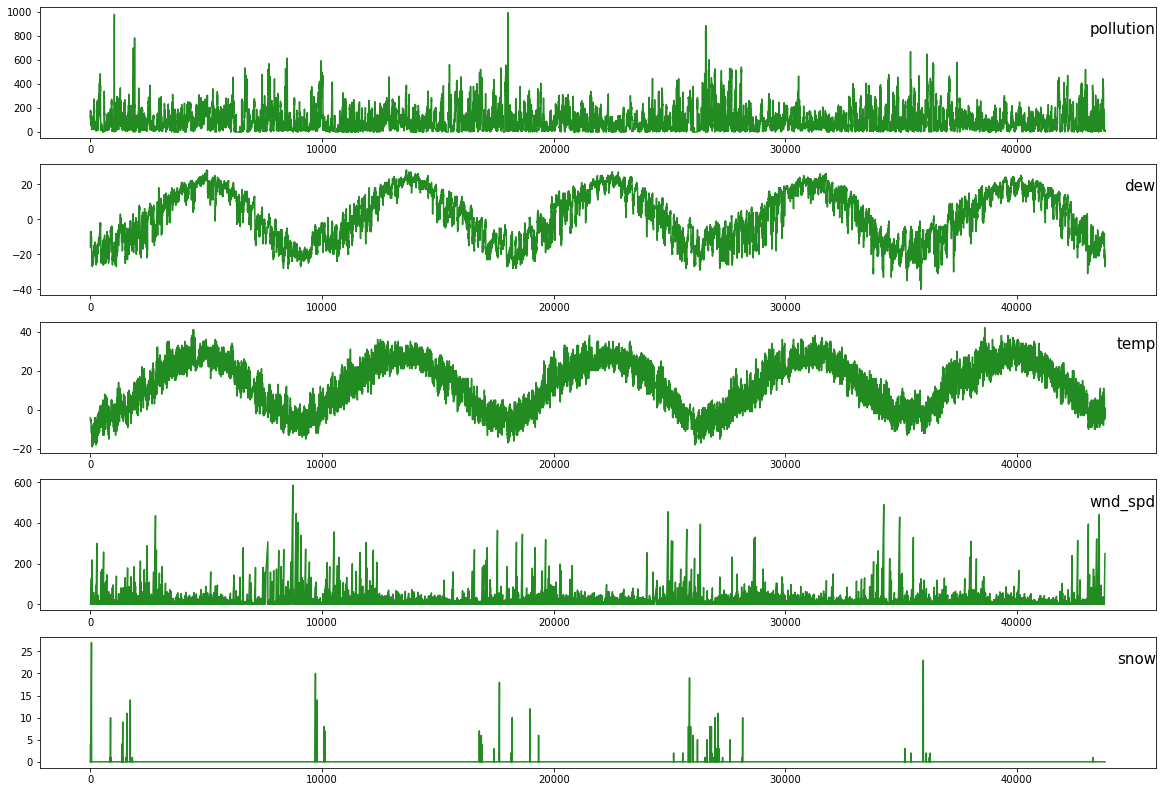

In [8]:
values = df.values

# specify columns to plot
groups = [1, 2, 3, 5, 6]
i = 1

# plot each column
plt.figure(figsize=(20,14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], c = "forestgreen")
    plt.title(df.columns[group], y=0.75, loc='right', fontsize = 15)
    i += 1
plt.show()

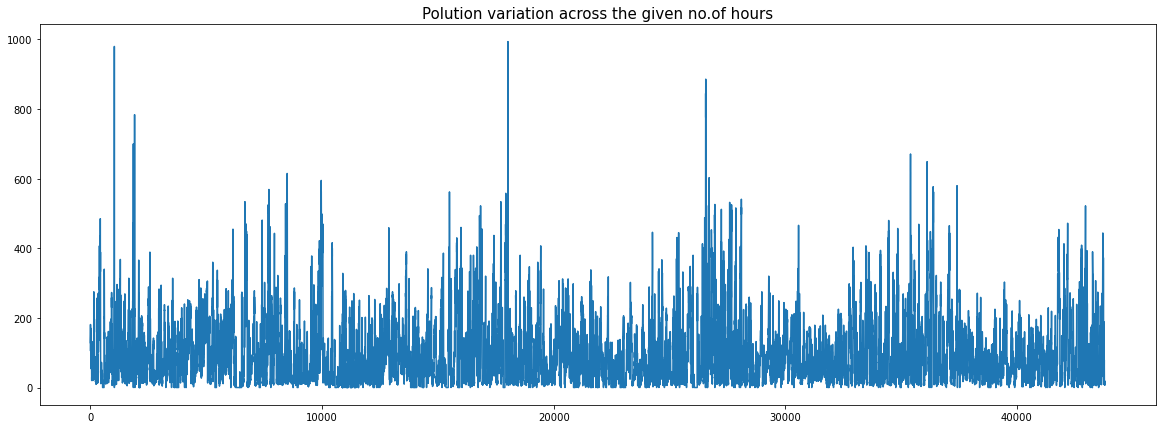

In [9]:
fig = plt.figure(figsize = (20,7))
plt.plot(df.pollution)
plt.title("Polution variation across the given no.of hours", fontsize = 15)
plt.show()

In [10]:
del df["date"]

In [11]:
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [12]:
# Scaling the entire dataset

dataset = df
values = dataset.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [39]:
# converting the dataset as supervised learning

reframed = series_to_supervised(scaled, 1, 1)
print(reframed.shape)

(43799, 16)


In [40]:
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.002290   0.000000   
2   0.148893   0.367647   0.245902   0.527273   0.003811   0.000000   
3   0.159960   0.426471   0.229508   0.545454   0.005332   0.000000   
4   0.182093   0.485294   0.229508   0.563637   0.008391   0.037037   
5   0.138833   0.485294   0.229508   0.563637   0.009912   0.074074   

   var7(t-1)  var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
1        0.0        0.0  0.148893  0.367647  0.245902  0.527273  0.003811   
2        0.0        0.0  0.159960  0.426471  0.229508  0.545454  0.005332   
3        0.0        0.0  0.182093  0.485294  0.229508  0.563637  0.008391   
4        0.0        0.0  0.138833  0.485294  0.229508  0.563637  0.009912   
5        0.0        0.0  0.109658  0.485294  0.213115  0.563637  0.011433   

    var6(t)  var7(t)  var8(t)  
1  0.000000      0.0      0.0  
2  0.000000      0.0      0.0  
3  0.037037   

In [41]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var1(t)', 'var2(t)', 'var3(t)',
       'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)', 'var8(t)'],
      dtype='object')

In [42]:
# droping columns we don't want to predict

# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
# Drop last N columns of dataframe
reframed.drop(columns=reframed.columns[-7:], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.002290   0.000000   
2   0.148893   0.367647   0.245902   0.527273   0.003811   0.000000   
3   0.159960   0.426471   0.229508   0.545454   0.005332   0.000000   
4   0.182093   0.485294   0.229508   0.563637   0.008391   0.037037   
5   0.138833   0.485294   0.229508   0.563637   0.009912   0.074074   

   var7(t-1)  var8(t-1)   var1(t)  
1        0.0        0.0  0.148893  
2        0.0        0.0  0.159960  
3        0.0        0.0  0.182093  
4        0.0        0.0  0.138833  
5        0.0        0.0  0.109658  


In [43]:
# Splitting the training data given into training and testing data for now
values = reframed.values

# We train the model on the 1st 3 years and then test on the last year (for now)
n_train_hours = 365 * 24 * 3

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 1, 8) (26280,) (17519, 1, 8) (17519,)


In [44]:
train.shape, test.shape, values.shape

((26280, 9), (17519, 9), (43799, 9))

In [19]:
# Designing some neural nets and training them
# Creating and testing on a model, which has about 64 LSTM units

In [21]:
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_split=0.2, verbose=2, shuffle=False)

2022-06-11 15:45:59.955161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
292/292 - 3s - loss: 0.0057 - val_loss: 0.0036 - 3s/epoch - 9ms/step
Epoch 2/50
292/292 - 0s - loss: 0.0017 - val_loss: 0.0019 - 445ms/epoch - 2ms/step
Epoch 3/50
292/292 - 0s - loss: 0.0010 - val_loss: 9.7535e-04 - 441ms/epoch - 2ms/step
Epoch 4/50
292/292 - 0s - loss: 8.9843e-04 - val_loss: 7.3518e-04 - 427ms/epoch - 1ms/step
Epoch 5/50
292/292 - 0s - loss: 8.6084e-04 - val_loss: 6.6643e-04 - 450ms/epoch - 2ms/step
Epoch 6/50
292/292 - 0s - loss: 8.4922e-04 - val_loss: 6.4308e-04 - 440ms/epoch - 2ms/step
Epoch 7/50
292/292 - 0s - loss: 8.4465e-04 - val_loss: 6.3144e-04 - 451ms/epoch - 2ms/step
Epoch 8/50
292/292 - 0s - loss: 8.4140e-04 - val_loss: 6.1925e-04 - 458ms/epoch - 2ms/step
Epoch 9/50
292/292 - 0s - loss: 8.3888e-04 - val_loss: 6.0689e-04 - 453ms/epoch - 2ms/step
Epoch 10/50
292/292 - 0s - loss: 8.3772e-04 - val_loss: 5.9722e-04 - 459ms/epoch - 2ms/step
Epoch 11/50
292/292 - 0s - loss: 8.3758e-04 - val_loss: 5.8956e-04 - 425ms/epoch - 1ms/step
Epoch 12/50
292/292 

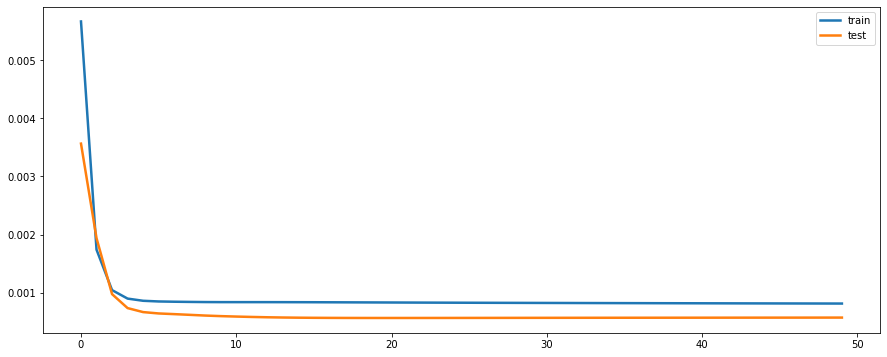

In [22]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [23]:
testPredict = model.predict(test_X)
print(testPredict.shape)
testPredict = testPredict.ravel()

print(testPredict.shape)

548/548 [==============================] - 1s 827us/step
(17519, 1)
(17519,)


In [24]:
y_test_true = test[:,8]
poll = np.array(df["pollution"])

meanop = poll.mean()
stdop = poll.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop

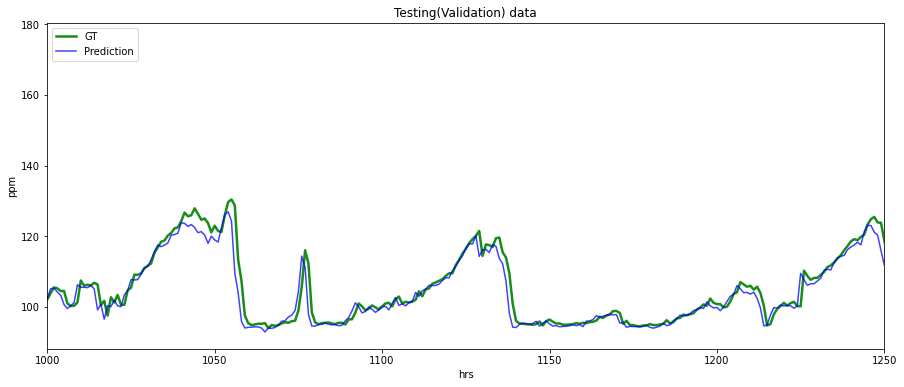

In [63]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5,label="GT")
plt.plot(testPredict, c = "b", alpha = 0.75,label="Prediction")
plt.title("Testing(Validation) data")
plt.legend(loc="upper left")
plt.show()

In [26]:
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))
print("Test(Validation) RMSE ="  ,rmse)

Test(Validation) RMSE = 2.5841196


Try adding more temporal variables

In [27]:
# converting the dataset as supervised learning

reframed = series_to_supervised(scaled, 3, 1)
print(reframed.shape)
print(reframed.head())

(43797, 32)
   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.129779   0.352941   0.245902   0.527273   0.002290   0.000000   
4   0.148893   0.367647   0.245902   0.527273   0.003811   0.000000   
5   0.159960   0.426471   0.229508   0.545454   0.005332   0.000000   
6   0.182093   0.485294   0.229508   0.563637   0.008391   0.037037   
7   0.138833   0.485294   0.229508   0.563637   0.009912   0.074074   

   var7(t-3)  var8(t-3)  var1(t-2)  var2(t-2)  ...  var7(t-1)  var8(t-1)  \
3        0.0        0.0   0.148893   0.367647  ...        0.0        0.0   
4        0.0        0.0   0.159960   0.426471  ...        0.0        0.0   
5        0.0        0.0   0.182093   0.485294  ...        0.0        0.0   
6        0.0        0.0   0.138833   0.485294  ...        0.0        0.0   
7        0.0        0.0   0.109658   0.485294  ...        0.0        0.0   

    var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  var7(t)  \
3  0.182093  0.485294  0.22950

In [28]:
# Drop last N columns of dataframe
reframed.drop(columns=reframed.columns[-7:], axis=1, inplace=True)
print(reframed.head())

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.129779   0.352941   0.245902   0.527273   0.002290   0.000000   
4   0.148893   0.367647   0.245902   0.527273   0.003811   0.000000   
5   0.159960   0.426471   0.229508   0.545454   0.005332   0.000000   
6   0.182093   0.485294   0.229508   0.563637   0.008391   0.037037   
7   0.138833   0.485294   0.229508   0.563637   0.009912   0.074074   

   var7(t-3)  var8(t-3)  var1(t-2)  var2(t-2)  ...  var8(t-2)  var1(t-1)  \
3        0.0        0.0   0.148893   0.367647  ...        0.0   0.159960   
4        0.0        0.0   0.159960   0.426471  ...        0.0   0.182093   
5        0.0        0.0   0.182093   0.485294  ...        0.0   0.138833   
6        0.0        0.0   0.138833   0.485294  ...        0.0   0.109658   
7        0.0        0.0   0.109658   0.485294  ...        0.0   0.105634   

   var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var7(t-1)  \
3   0.426471   0.229508   0.545454   0.005332

In [29]:
# Splitting the training data given into training and testing data for now
values = reframed.values

# We train the model on the 1st 3 years and then test on the last year (for now)
n_train_hours = 365 * 24 * 3

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 1, 24) (26280,) (17517, 1, 24) (17517,)


In [30]:
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/50
292/292 - 2s - loss: 0.0031 - val_loss: 0.0016 - 2s/epoch - 8ms/step
Epoch 2/50
292/292 - 0s - loss: 0.0013 - val_loss: 9.3060e-04 - 436ms/epoch - 1ms/step
Epoch 3/50
292/292 - 0s - loss: 0.0011 - val_loss: 7.7237e-04 - 434ms/epoch - 1ms/step
Epoch 4/50
292/292 - 0s - loss: 9.8775e-04 - val_loss: 6.9608e-04 - 441ms/epoch - 2ms/step
Epoch 5/50
292/292 - 0s - loss: 9.3214e-04 - val_loss: 6.6702e-04 - 455ms/epoch - 2ms/step
Epoch 6/50
292/292 - 0s - loss: 8.9788e-04 - val_loss: 6.2800e-04 - 499ms/epoch - 2ms/step
Epoch 7/50
292/292 - 0s - loss: 8.8446e-04 - val_loss: 6.1080e-04 - 450ms/epoch - 2ms/step
Epoch 8/50
292/292 - 0s - loss: 8.7879e-04 - val_loss: 6.0427e-04 - 451ms/epoch - 2ms/step
Epoch 9/50
292/292 - 0s - loss: 8.7423e-04 - val_loss: 6.0071e-04 - 456ms/epoch - 2ms/step
Epoch 10/50
292/292 - 1s - loss: 8.7016e-04 - val_loss: 5.9835e-04 - 534ms/epoch - 2ms/step
Epoch 11/50
292/292 - 1s - loss: 8.6664e-04 - val_loss: 5.9675e-04 - 510ms/epoch - 2ms/step
Epoch 12/50
292/

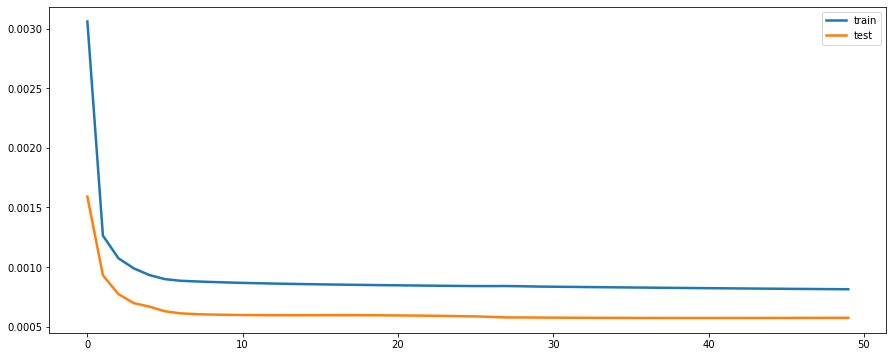

In [33]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [34]:
testPredict = model.predict(test_X)
print(testPredict.shape)
testPredict = testPredict.ravel()

print(testPredict.shape)

548/548 [==============================] - 1s 1ms/step
(17517, 1)
(17517,)


In [35]:
y_test_true = test[:,-1]
poll = np.array(df["pollution"])

meanop = poll.mean()
stdop = poll.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop

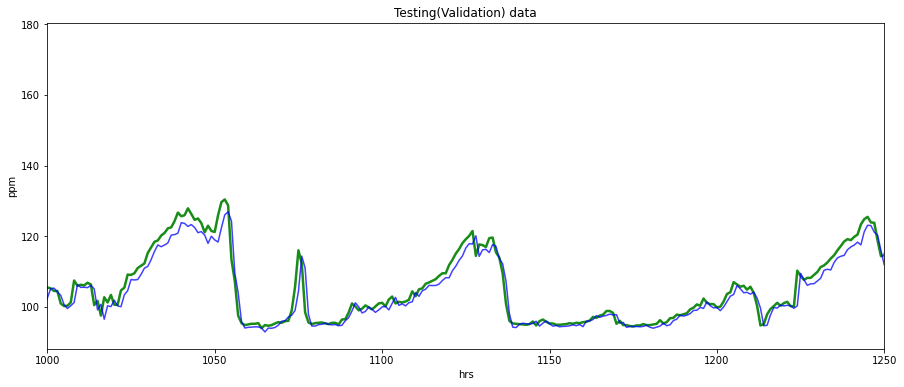

In [36]:
plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

In [37]:
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))
print("Test(Validation) RMSE ="  ,rmse)

Test(Validation) RMSE = 2.6173556


Bigger LSTM model

In [45]:
model2 = Sequential()
model2.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(Dense(64))
model2.add(Dropout(0.25))
model2.add(BatchNormalization())
model2.add(Dense(1))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256)               271360    
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 288,129
Trainable params: 288,001
Non-trainable params: 128
______________________________________________

In [46]:
model2.compile(loss='mse', optimizer='adam')

hist2 = model2.fit(train_X, train_y, epochs=50, batch_size=128, validation_data=(test_X, test_y))

Epoch 1/50
206/206 [==============================] - 4s 9ms/step - loss: 0.0098 - val_loss: 0.0084
Epoch 2/50
206/206 [==============================] - 1s 6ms/step - loss: 0.0017 - val_loss: 0.0056
Epoch 3/50
206/206 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 4/50
206/206 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 5/50
206/206 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 6/50
206/206 [==============================] - 2s 7ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 7/50
206/206 [==============================] - 1s 6ms/step - loss: 0.0014 - val_loss: 7.9157e-04
Epoch 8/50
206/206 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/50
206/206 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/50
206/206 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.

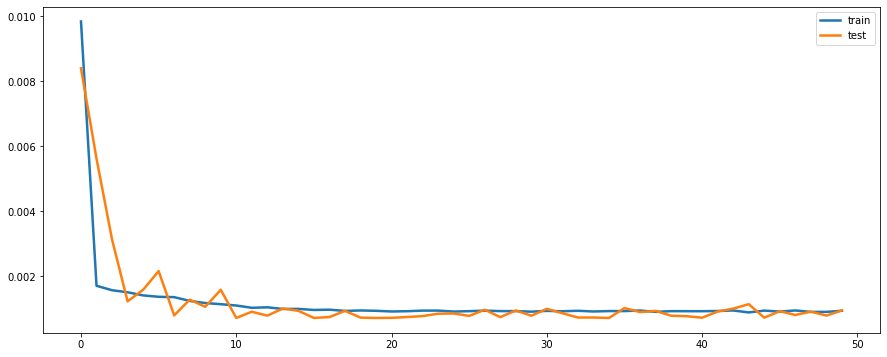

In [47]:
plt.figure(figsize=(15,6))
plt.plot(hist2.history['loss'], label='train', linewidth = 2.5)
plt.plot(hist2.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [59]:
y_test_true = test[:,-1]
testPredict2 = model2.predict(test_X)
testPredict2 = testPredict2.ravel()

# Inverse scaling the output, for better visual interpretation 

poll = np.array(df["pollution"])
meanop = poll.mean()
stdop = poll.std()

print(meanop, stdop)

y_test_true = y_test_true*stdop + meanop
testPredict2 = testPredict2*stdop + meanop

548/548 [==============================] - 1s 1ms/step
94.01351598173515 92.25122315439845


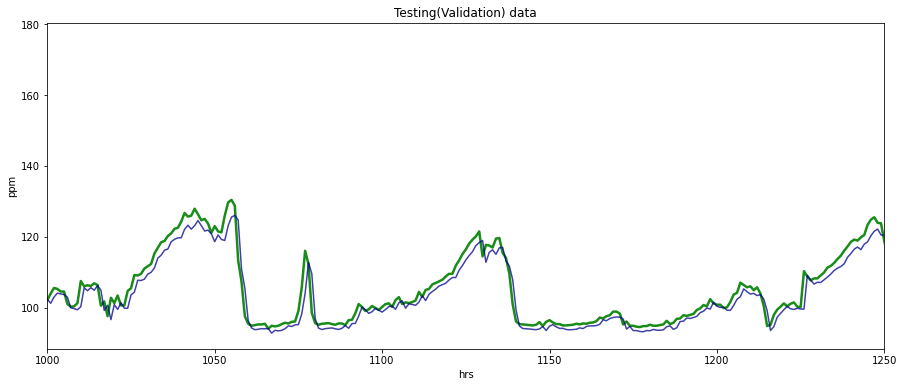

In [60]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict2, c = "darkblue", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

In [61]:
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict2))
print("Test(Validation) RMSE ="  ,rmse)

Test(Validation) RMSE = 2.836456
